# Protein MD Setup tutorial using BioExcel Building Blocks (biobb)
### Based on the official Gromacs tutorial: http://www.mdtutorials.com/gmx/lysozyme/index.html
***
This tutorial aims to illustrate the process of **setting up a simulation system** containing a **protein**, step by step, using the **BioExcel Building Blocks library (biobb)**. The particular example used is the **Lysozyme** protein (PDB code 1AKI). 
***
**Biobb modules** used:

 - [biobb_io](https://github.com/bioexcel/biobb_io): Tools to fetch biomolecular data from public databases.
 - [biobb_model](https://github.com/bioexcel/biobb_model): Tools to model macromolecular structures.
 - [biobb_md](https://github.com/bioexcel/biobb_md): Tools to setup and run Molecular Dynamics simulations.
 - [biobb_analysis](https://github.com/bioexcel/biobb_analysis): Tools to analyse Molecular Dynamics trajectories.
 
**Auxiliar libraries** used:

 - [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
 - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets): Interactive HTML widgets for Jupyter notebooks and the IPython kernel.
 - [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.

Conda **Installation**:

 - **conda install -c bioconda biobb_MD_setup**   ////  *NOTE: this is not yet available*  ////

***
### Pipeline steps:
 1. [Input Parameters](#input)
 2. [Fetching PDB Structure](#fetch)
 3. [Fix Protein Structure](#fix)
 4. [Create Protein System Topology](#top)
 5. [Create Solvent Box](#box)
 6. [Fill the Box with Water Molecules](#water)
 7. [Adding Ions](#ions)
 8. [Energetically Minimize the System](#min)
 9. [Equilibrate the System (NVT)](#nvt)
 10. [Equilibrate the System (NPT)](#npt)
 11. [Free Molecular Dynamics Simulation](#free)
 12. [Post-processing and Visualizing Resulting 3D Trajectory](#post)
 13. [Output Files](#output)
 
***
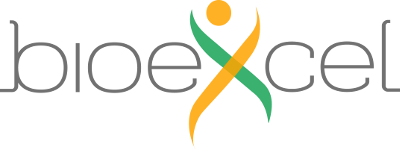
***


<a id="input"></a>
***
## Input parameters
**Input parameters** needed:
 - **pdbCode**: PDB code of the protein structure (e.g. 1AKI)

In [ ]:
import nglview
import ipywidgets

pdbCode = "1AKI"

<a id="fetch"></a>
***
## Fetching PDB structure
Downloading **PDB structure** with the **protein molecule** from the RCSB PDB database.<br>
Alternatively, a **PDB file** can be used as starting structure. <br>
***
**Building Blocks** used:
 - [Pdb](https://biobb-io.readthedocs.io/en/latest/api.html#module-api.pdb) from **biobb_io.api.pdb**
***

In [ ]:
# Downloading desired PDB file 
# Import module
from biobb_io.api.pdb import Pdb

# Create properties dict and inputs/outputs
downloaded_pdb = pdbCode+'.pdb'
prop = {
    'pdb_code': pdbCode
}

#Create and launch bb
Pdb(output_pdb_path=downloaded_pdb,
    properties=prop).launch()

<a id="vis3D"></a>
### Visualizing 3D structure
Visualizing the downloaded/given **PDB structure** using **NGL**:    

In [ ]:
# Show protein
view = nglview.show_file(downloaded_pdb)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view

<a id="fix"></a>
***
## Fix protein structure
**Checking** and **fixing** (if needed) the protein structure:<br>
- **Modeling** **missing side-chain atoms**, modifying incorrect **amide assignments**, choosing **alternative locations**.<br>
- **Checking** for missing **backbone atoms**, **heteroatoms**, **modified residues** and possible **atomic clashes**.

***
**Building Blocks** used:
 - [FixSideChain](https://biobb-model.readthedocs.io/en/latest/model.html#module-model.fix_side_chain) from **biobb_model.model.fix_side_chain**
***

In [ ]:
# Check & Fix PDB
# Import module
from biobb_model.model.fix_side_chain import FixSideChain

# Create prop dict and inputs/outputs
fixed_pdb = pdbCode + '_fixed.pdb'

# Create and launch bb
FixSideChain(input_pdb_path=downloaded_pdb, 
             output_pdb_path=fixed_pdb).launch()

### Visualizing 3D structure
Visualizing the fixed **PDB structure** using **NGL**. In this particular example, the checking step didn't find any issue to be solved, so there is no difference between the original structure and the fixed one.   

In [ ]:
# Show protein
view = nglview.show_file(fixed_pdb)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

<a id="top"></a>
***
## Create protein system topology
**Building GROMACS topology** corresponding to the protein structure.<br>
Force field used in this tutorial is [**amber99sb-ildn**](https://dx.doi.org/10.1002%2Fprot.22711): AMBER **parm99** force field with **corrections on backbone** (sb) and **side-chain torsion potentials** (ildn). Water molecules type used in this tutorial is [**spc/e**](https://pubs.acs.org/doi/abs/10.1021/j100308a038).<br>
Adding **hydrogen atoms** if missing. Automatically identifying **disulfide bridges**. <br>

Generating two output files: 
- **GROMACS structure** (gro file)
- **GROMACS topology** ZIP compressed file containing:
    - *GROMACS topology top file* (top file)
    - *GROMACS position restraint file/s* (itp file/s)
***
**Building Blocks** used:
 - [Pdb2gmx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.pdb2gmx) from **biobb_md.gromacs.pdb2gmx**
***

In [ ]:
# Create system topology
# Import module
from biobb_md.gromacs.pdb2gmx import Pdb2gmx

# Create inputs/outputs
output_pdb2gmx_gro = pdbCode+'_pdb2gmx.gro'
output_pdb2gmx_top_zip = pdbCode+'_pdb2gmx_top.zip'

# Create and launch bb
Pdb2gmx(input_pdb_path=fixed_pdb, 
        output_gro_path=output_pdb2gmx_gro, 
        output_top_zip_path=output_pdb2gmx_top_zip).launch()

### Visualizing 3D structure
Visualizing the generated **GRO structure** using **NGL**. Note that **hydrogen atoms** were added to the structure by the **pdb2gmx GROMACS tool** when generating the **topology**.    

In [ ]:
# Show protein
view = nglview.show_file(output_pdb2gmx_gro)
view.add_representation(repr_type='ball+stick', selection='all')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

<a id="box"></a>
***
## Create solvent box
Define the unit cell for the **protein structure MD system** to fill it with water molecules.<br>
A **cubic box** is used to define the unit cell, with a **distance from the protein to the box edge of 1.0 nm**. The protein is **centered in the box**.  

***
**Building Blocks** used:
 - [Editconf](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.editconf) from **biobb_md.gromacs.editconf** 
***

In [ ]:
# Editconf: Create solvent box
# Import module
from biobb_md.gromacs.editconf import Editconf

# Create prop dict and inputs/outputs
output_editconf_gro = pdbCode+'_editconf.gro'

prop = {
    'box_type': 'cubic',
    'distance_to_molecule': 1.0
}

#Create and launch bb
Editconf(input_gro_path=output_pdb2gmx_gro, 
         output_gro_path=output_editconf_gro,
         properties=prop).launch()

<a id="water"></a>
***
## Fill the box with water molecules
Fill the unit cell for the **protein structure system** with water molecules.<br>
The solvent type used is the default **Simple Point Charge water (SPC)**, a generic equilibrated 3-point solvent model. 

***
**Building Blocks** used:
 - [Solvate](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.solvate) from **biobb_md.gromacs.solvate** 
***

In [ ]:
# Solvate: Fill the box with water molecules
from biobb_md.gromacs.solvate import Solvate

# Create prop dict and inputs/outputs
output_solvate_gro = pdbCode+'_solvate.gro'
output_solvate_top_zip = pdbCode+'_solvate_top.zip'

# Create and launch bb
Solvate(input_solute_gro_path=output_editconf_gro, 
        output_gro_path=output_solvate_gro, 
        input_top_zip_path=output_pdb2gmx_top_zip, 
        output_top_zip_path=output_solvate_top_zip).launch()

### Visualizing 3D structure
Visualizing the **protein system** with the newly added **solvent box** using **NGL**.<br> Note the **cubic box** filled with **water molecules** surrounding the **protein structure**, which is **centered** right in the middle of the cube.

In [ ]:
# Show protein
view = nglview.show_file(output_solvate_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='solute', color='green')
view.add_representation(repr_type='ball+stick', selection='SOL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

<a id="ions"></a>
***
## Adding ions
Add ions to neutralize the **protein structure** charge
- [Step 1](#ionsStep1): Creating portable binary run file for ion generation
- [Step 2](#ionsStep2): Adding ions to **neutralize** the system
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Genion](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genion) from **biobb_md.gromacs.genion** 
***

<a id="ionsStep1"></a>
### Step 1: Creating portable binary run file for ion generation
A simple **energy minimization** molecular dynamics parameters (mdp) properties will be used to generate the portable binary run file for **ion generation**, although **any legitimate combination of parameters** could be used in this step.

In [ ]:
# Grompp: Creating portable binary run file for ion generation
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppion_tpr = pdbCode+'_gppion.tpr'
prop = {
    'mdp':{
        'type': 'minimization'
    }
}

# Create and launch bb
Grompp(input_gro_path=output_solvate_gro, 
       input_top_zip_path=output_solvate_top_zip, 
       output_tpr_path=output_gppion_tpr,  
       properties=prop).launch()

<a id="ionsStep2"></a>
### Step 2: Adding ions to neutralize the system
Replace **solvent molecules** with **ions** to **neutralize** the system.

In [ ]:
# Genion: Adding ions to neutralize the system
from biobb_md.gromacs.genion import Genion

# Create prop dict and inputs/outputs
output_genion_gro = pdbCode+'_genion.gro'
output_genion_top_zip = pdbCode+'_genion_top.zip'
prop={
    'neutral':True
}

# Create and launch bb
Genion(input_tpr_path=output_gppion_tpr, 
       output_gro_path=output_genion_gro, 
       input_top_zip_path=output_solvate_top_zip, 
       output_top_zip_path=output_genion_top_zip, 
       properties=prop).launch()

### Visualizing 3D structure
Visualizing the **neutralized protein system** with the newly added **ions** using **NGL**

In [ ]:
# Show protein
view = nglview.show_file(output_genion_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='solute', color='sstruc')
view.add_representation(repr_type='ball+stick', selection='NA')
view.add_representation(repr_type='ball+stick', selection='CL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

<a id="min"></a>
***
## Energetically minimize the system
Energetically minimize the **protein system** till reaching a desired potential energy.
- [Step 1](#emStep1): Creating portable binary run file for energy minimization
- [Step 2](#emStep2): Energetically minimize the **system** till reaching a force of 500 kJ mol-1 nm-1.
- [Step 3](#emStep3): Checking **energy minimization** results. Plotting energy by time during the **minimization** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="emStep1"></a>
### Step 1: Creating portable binary run file for energy minimization
The **minimization** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **energy minimization**:

-  integrator  = steep ; Algorithm (steep = steepest descent minimization)
-  emtol       = 1000.0 ; Stop minimization when the maximum force < 1000.0 kJ/mol/nm
-  emstep      = 0.01 ; Minimization step size (nm)
-  nsteps      = 50000 ; Maximum number of (minimization) steps to perform

In this particular example, the method used to run the **energy minimization** is the default **steepest descent**, but the **maximum force** is placed at **500 KJ/mol\*nm^2**, and the **maximum number of steps** to perform (if the maximum force is not reached) to **5,000 steps**. 

In [ ]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppmin_tpr = pdbCode+'_gppmin.tpr'
prop = {
    'mdp':{
        'type': 'minimization',
        'emtol':'500',
        'nsteps':'5000'
    }
}

# Create and launch bb
Grompp(input_gro_path=output_genion_gro, 
       input_top_zip_path=output_genion_top_zip, 
       output_tpr_path=output_gppmin_tpr,  
       properties=prop).launch()

<a id="emStep2"></a>
### Step 2: Running Energy Minimization
Running **energy minimization** using the **tpr file** generated in the previous step. 

In [ ]:
# Mdrun: Running minimization
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_min_trr = pdbCode+'_min.trr'
output_min_gro = pdbCode+'_min.gro'
output_min_edr = pdbCode+'_min.edr'
output_min_log = pdbCode+'_min.log'

# Create and launch bb
Mdrun(input_tpr_path=output_gppmin_tpr, 
      output_trr_path=output_min_trr, 
      output_gro_path=output_min_gro, 
      output_edr_path=output_min_edr, 
      output_log_path=output_min_log).launch()

<a id="emStep3"></a>
### Step 3: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the minimization process. 

In [ ]:
# GMXEnergy: Getting system energy by time  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_min_ene_xvg = pdbCode+'_min_ene.xvg'
prop = {
    'terms':  ["Potential"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_min_edr, 
          output_xvg_path=output_min_ene_xvg, 
          properties=prop).launch()

In [ ]:
import plotly
import plotly.graph_objs as go

#Read data from file and filter energy values higher than 1000 Kj/mol^-1
with open(output_min_ene_xvg,'r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy KJ/mol-1")
                       )
})

<a id="nvt"></a>
***
## Equilibrate the system (NVT)
Equilibrate the **protein system** in **NVT ensemble** (constant Number of particles, Volume and Temperature). Protein **heavy atoms** will be restrained using position restraining forces: movement is permitted, but only after overcoming a substantial energy penalty. The utility of position restraints is that they allow us to equilibrate our solvent around our protein, without the added variable of structural changes in the protein.

- [Step 1](#eqNVTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNVTStep2): Equilibrate the **protein system** with **NVT** ensemble.
- [Step 3](#eqNVTStep3): Checking **NVT Equilibration** results. Plotting **system temperature** by time during the **NVT equilibration** process. 
***
**Building Blocks** used:
- [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
- [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
- [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNVTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NVT)
The **nvt** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **NVT equilibration** with **protein restraints** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  Define                   = -DPOSRES
-  integrator               = md
-  dt                       = 0.002
-  nsteps                   = 5000
-  pcoupl                   = no
-  gen_vel                  = yes
-  gen_temp                 = 300
-  gen_seed                 = -1

In this particular example, the default parameters will be used: **md** integrator algorithm, a **step size** of **2fs**, **5,000 equilibration steps** with the protein **heavy atoms restrained**, and a temperature of **300K**.

*Please note that for the sake of time this tutorial is only running 10ps of NVT equilibration, whereas in the [original example](http://www.mdtutorials.com/gmx/lysozyme/06_equil.html) the simulated time was 100ps.*

In [ ]:
# Grompp: Creating portable binary run file for NVT Equilibration
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppnvt_tpr = pdbCode+'_gppnvt.tpr'
prop = {
    'mdp':{
        'type': 'nvt',
        'nsteps': 5000,
        'dt': 0.002,
        'define': '-DPOSRES',
        #'tc_grps': "DNA Water_and_ions" # NOTE: uncomment this line if working with DNA
    }
}

# Create and launch bb
Grompp(input_gro_path=output_min_gro, 
       input_top_zip_path=output_genion_top_zip, 
       output_tpr_path=output_gppnvt_tpr,  
       properties=prop).launch()

<a id="eqNVTStep2"></a>
### Step 2: Running NVT equilibration

In [ ]:
# Mdrun: Running Equilibration NVT
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_nvt_trr = pdbCode+'_nvt.trr'
output_nvt_gro = pdbCode+'_nvt.gro'
output_nvt_edr = pdbCode+'_nvt.edr'
output_nvt_log = pdbCode+'_nvt.log'
output_nvt_cpt = pdbCode+'_nvt.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppnvt_tpr, 
      output_trr_path=output_nvt_trr, 
      output_gro_path=output_nvt_gro, 
      output_edr_path=output_nvt_edr, 
      output_log_path=output_nvt_log, 
      output_cpt_path=output_nvt_cpt).launch()

<a id="eqNVTStep3"></a>
### Step 3: Checking NVT Equilibration results
Checking **NVT Equilibration** results. Plotting **system temperature** by time during the NVT equilibration process. 

In [ ]:
# GMXEnergy: Getting system temperature by time during NVT Equilibration  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_nvt_temp_xvg = pdbCode+'_nvt_temp.xvg'
prop = {
    'terms':  ["Temperature"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_nvt_edr, 
          output_xvg_path=output_nvt_temp_xvg, 
          properties=prop).launch()

In [ ]:
import plotly
import plotly.graph_objs as go

# Read temperature data from file 
with open(output_nvt_temp_xvg,'r') as temperature_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in temperature_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Temperature during NVT Equilibration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Temperature (K)")
                       )
})

<a id="npt"></a>
***
## Equilibrate the system (NPT)
Equilibrate the **protein system** in **NPT** ensemble (constant Number of particles, Pressure and Temperature).
- [Step 1](#eqNPTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNPTStep2): Equilibrate the **protein system** with **NPT** ensemble.
- [Step 3](#eqNPTStep3): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNPTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NPT)

The **npt** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **NPT equilibration** with **protein restraints** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  Define                   = -DPOSRES
-  integrator               = md
-  dt                       = 0.002
-  nsteps                   = 5000
-  pcoupl = Parrinello-Rahman
-  pcoupltype = isotropic
-  tau_p = 1.0
-  ref_p = 1.0
-  compressibility = 4.5e-5
-  refcoord_scaling = com
-  gen_vel = no

In this particular example, the default parameters will be used: **md** integrator algorithm, a **time step** of **2fs**, **5,000 equilibration steps** with the protein **heavy atoms restrained**, and a Parrinello-Rahman **pressure coupling** algorithm.

*Please note that for the sake of time this tutorial is only running 10ps of NPT equilibration, whereas in the [original example](http://www.mdtutorials.com/gmx/lysozyme/07_equil2.html) the simulated time was 100ps.*

In [ ]:
# Grompp: Creating portable binary run file for NPT System Equilibration
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppnpt_tpr = pdbCode+'_gppnpt.tpr'
prop = {
    'mdp':{
        'type': 'npt',
        'nsteps':'5000',
        #'tc_grps': "DNA Water_and_ions" # NOTE: uncomment this line if working with DNA
    }
}

# Create and launch bb
Grompp(input_gro_path=output_nvt_gro, 
       input_top_zip_path=output_genion_top_zip, 
       output_tpr_path=output_gppnpt_tpr, 
       input_cpt_path=output_nvt_cpt,  
       properties=prop).launch()

<a id="eqNPTStep2"></a>
### Step 2: Running NPT equilibration

In [ ]:
# Mdrun: Running NPT System Equilibration
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_npt_trr = pdbCode+'_npt.trr'
output_npt_gro = pdbCode+'_npt.gro'
output_npt_edr = pdbCode+'_npt.edr'
output_npt_log = pdbCode+'_npt.log'
output_npt_cpt = pdbCode+'_npt.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppnpt_tpr, 
      output_trr_path=output_npt_trr, 
      output_gro_path=output_npt_gro, 
      output_edr_path=output_npt_edr, 
      output_log_path=output_npt_log, 
      output_cpt_path=output_npt_cpt).launch()

<a id="eqNPTStep3"></a>
### Step 3: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [ ]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_npt_pd_xvg = pdbCode+'_npt_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_npt_edr, 
          output_xvg_path=output_npt_pd_xvg, 
          properties=prop).launch()

In [ ]:
import plotly
from plotly import tools
import plotly.graph_objs as go

# Read pressure and density data from file 
with open(output_npt_pd_xvg,'r') as pd_file:
    x,y,z = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]),float(line.split()[2]))
            for line in pd_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = tools.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (Kg*m^-3)')

fig['layout'].update(title='Pressure and Density during NPT Equilibration')
fig['layout'].update(showlegend=False)

plotly.offline.iplot(fig)

<a id="free"></a>
***
## Free Molecular Dynamics Simulation
Upon completion of the **two equilibration phases (NVT and NPT)**, the system is now well-equilibrated at the desired temperature and pressure. The **position restraints** can now be released. The last step of the **protein** MD setup is a short, **free MD simulation**, to ensure the robustness of the system. 
- [Step 1](#mdStep1): Creating portable binary run file to run a **free MD simulation**.
- [Step 2](#mdStep2): Run short MD simulation of the **protein system**.
- [Step 3](#mdStep3): Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. 
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXRms](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rms) from **biobb_analysis.gromacs.gmx_rms** 
 - [GMXRgyr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rgyr) from **biobb_analysis.gromacs.gmx_rgyr** 
***

<a id="mdStep1"></a>
### Step 1: Creating portable binary run file to run a free MD simulation

The **free** type of the **molecular dynamics parameters (mdp) property** contains the main default parameters to run an **free MD simulation** (see [GROMACS mdp options](http://manual.gromacs.org/documentation/2018/user-guide/mdp-options.html)):

-  integrator               = md
-  dt                       = 0.002 (ps)
-  nsteps                   = 50000

In this particular example, the default parameters will be used: **md** integrator algorithm, a **time step** of **2fs**, and a total of **50,000 md steps** (100ps).

*Please note that for the sake of time this tutorial is only running 100ps of free MD, whereas in the [original example](http://www.mdtutorials.com/gmx/lysozyme/08_MD.html) the simulated time was 1ns (1000ps).*

In [ ]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppmd_tpr = pdbCode+'_gppmd.tpr'
prop = {
    'mdp':{
        'type': 'free',
        'nsteps':'50000',
        #'tc_grps': "DNA Water_and_ions" # NOTE: uncomment this line if working with DNA
    }
}

# Create and launch bb
Grompp(input_gro_path=output_npt_gro, 
       input_top_zip_path=output_genion_top_zip, 
       output_tpr_path=output_gppmd_tpr, 
       input_cpt_path=output_npt_cpt, 
       properties=prop).launch()

<a id="mdStep2"></a>
### Step 2: Running short free MD simulation

In [ ]:
# Mdrun: Running free dynamics
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_md_trr = pdbCode+'_md.trr'
output_md_gro = pdbCode+'_md.gro'
output_md_edr = pdbCode+'_md.edr'
output_md_log = pdbCode+'_md.log'
output_md_cpt = pdbCode+'_md.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppmd_tpr, 
      output_trr_path=output_md_trr, 
      output_gro_path=output_md_gro, 
      output_edr_path=output_md_edr, 
      output_log_path=output_md_log, 
      output_cpt_path=output_md_cpt).launch()

<a id="mdStep3"></a>
### Step 3: Checking free MD simulation results
Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. **RMSd** against the **experimental structure** (input structure of the pipeline) and against the **minimized and equilibrated structure** (output structure of the NPT equilibration step).

In [ ]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against minimized and equilibrated snapshot (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import GMXRms

# Create prop dict and inputs/outputs
output_rms_first = pdbCode+'_rms_first.xvg'
prop = {
    'selection':  'Backbone',
    #'selection': 'non-Water'
}

# Create and launch bb
GMXRms(input_structure_path=output_gppmd_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rms_first, 
          properties=prop).launch()

In [ ]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against experimental structure (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import GMXRms

# Create prop dict and inputs/outputs
output_rms_exp = pdbCode+'_rms_exp.xvg'
prop = {
    'selection':  'Backbone',
    #'selection': 'non-Water'
}

# Create and launch bb
GMXRms(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rms_exp, 
          properties=prop).launch()

In [ ]:
import plotly
import plotly.graph_objs as go

# Read RMS vs first snapshot data from file 
with open(output_rms_first,'r') as rms_first_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_first_file 
            if not line.startswith(("#","@")) 
        ])
    )

# Read RMS vs experimental structure data from file 
with open(output_rms_exp,'r') as rms_exp_file:
    x2,y2 = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_exp_file
            if not line.startswith(("#","@")) 
        ])
    )
    
trace1 = go.Scatter(
    x = x,
    y = y,
    name = 'RMSd vs first'
)

trace2 = go.Scatter(
    x = x,
    y = y2,
    name = 'RMSd vs exp'
)

data = [trace1, trace2]

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": data,
    "layout": go.Layout(title="RMSd during free MD Simulation",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "RMSd (nm)")
                       )
})


In [ ]:
# GMXRgyr: Computing Radius of Gyration to measure the protein compactness during the free MD simulation 

from biobb_analysis.gromacs.gmx_rgyr import GMXRgyr

# Create prop dict and inputs/outputs
output_rgyr = pdbCode+'_rgyr.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
GMXRms(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rgyr, 
          properties=prop).launch()

In [ ]:
import plotly
import plotly.graph_objs as go

# Read Rgyr data from file 
with open(output_rgyr,'r') as rgyr_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rgyr_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

plotly.offline.iplot({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Radius of Gyration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Rgyr (nm)")
                       )
})

<a id="post"></a>
***
## Post-processing and Visualizing resulting 3D trajectory
Post-processing and Visualizing the **protein system** MD setup **resulting trajectory** using **NGL**
- [Step 1](#ppStep1): *Imaging* the resulting trajectory, **stripping out water molecules and ions** and **correcting periodicity issues**.
- [Step 2](#ppStep2): Generating a *dry* structure, **removing water molecules and ions** from the final snapshot of the MD setup pipeline.
- [Step 3](#ppStep3): Visualizing the *imaged* trajectory using the *dry* structure as a **topology**. 
***
**Building Blocks** used:
 - [GMXImage](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_image) from **biobb_analysis.gromacs.gmx_image** 
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str** 
***

<a id="ppStep1"></a>
### Step 1: *Imaging* the resulting trajectory.
Stripping out **water molecules and ions** and **correcting periodicity issues**  

In [ ]:
# GMXImage: "Imaging" the resulting trajectory
#           Removing water molecules and ions from the resulting structure
from biobb_analysis.gromacs.gmx_image import GMXImage

# Create prop dict and inputs/outputs
output_imaged_traj = pdbCode+'_imaged_traj.trr'
prop = {
    'center_selection':  'Protein',
    'output_selection': 'Protein',
    'pbc' : 'mol',
    'center' : True
}

# Create and launch bb
GMXImage(input_traj_path=output_md_trr,
         input_top_path=output_gppmd_tpr,
         output_traj_path=output_imaged_traj, 
          properties=prop).launch()

<a id="ppStep2"></a>
### Step 2: Generating the output *dry* structure.
**Removing water molecules and ions** from the resulting structure

In [ ]:
# GMXTrjConvStr: Converting and/or manipulating a structure
#                Removing water molecules and ions from the resulting structure
#                The "dry" structure will be used as a topology to visualize 
#                the "imaged dry" trajectory generated in the previous step.
from biobb_analysis.gromacs.gmx_trjconv_str import GMXTrjConvStr

# Create prop dict and inputs/outputs
output_dry_gro = pdbCode+'_md_dry.gro'
prop = {
    'selection':  'Protein'
}

# Create and launch bb
GMXTrjConvStr(input_structure_path=output_md_gro,
         input_top_path=output_gppmd_tpr,
         output_str_path=output_dry_gro, 
          properties=prop).launch()

<a id="ppStep3"></a>
### Step 3: Visualizing the generated dehydrated trajectory.
Using the **imaged trajectory** (output of the [Post-processing step 1](#ppStep1)) with the **dry structure** (output of the [Post-processing step 2](#ppStep2)) as a topology.

In [ ]:
# Show trajectory
nglview.show_simpletraj(nglview.SimpletrajTrajectory(output_imaged_traj, output_dry_gro), gui=True)

<a id="output"></a>
## Output files

Important **Output files** generated:
 - {{output_md_gro}}: **Final structure** (snapshot) of the MD setup protocol.
 - {{output_md_trr}}: **Final trajectory** of the MD setup protocol.
 - {{output_md_cpt}}: **Final checkpoint file**, with information about the state of the simulation. It can be used to **restart** or **continue** a MD simulation.
 - {{output_gppmd_tpr}}: **Final tpr file**, GROMACS portable binary run input file. This file contains the starting structure of the **MD setup free MD simulation step**, together with the molecular topology and all the simulation parameters. It can be used to **extend** the simulation.
 - {{output_genion_top_zip}}: **Final topology** of the MD system. It is a compressed zip file including a **topology file** (.top) and a set of auxiliar **include topology** files (.itp).

**Analysis** (MD setup check) output files generated:
 - {{output_rms_first}}: **Root Mean Square deviation (RMSd)** against **minimized and equilibrated structure** of the final **free MD run step**.
 - {{output_rms_exp}}: **Root Mean Square deviation (RMSd)** against **experimental structure** of the final **free MD run step**.
 - {{output_rgyr}}: **Radius of Gyration** of the final **free MD run step** of the **setup pipeline**.
 